In [1]:
import numpy as np
from scipy.io import savemat
from scipy.io import loadmat
from neurodsp.sim import sim_oscillation, sim_powerlaw
from neurodsp.plts import plot_time_series
from neurodsp.rhythm import sliding_window_matching

### Simulate Data
Here, we simulate a gaussian with steadily increasing lengths of white noise between each gaussian. If this varying-length white noise isn't inserted between gaussian, the result will have a random phase.

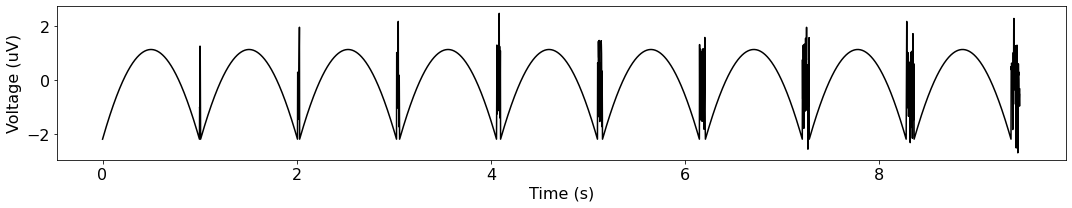

In [7]:
def sim_data(iterations, fs):
    
    sig = np.array([])
    
    for idx in range(1, iterations):
        
        sig_gaussian = sim_oscillation(1, fs, freq=1, cycle="gaussian", std=1)
        sig_wn = sim_powerlaw(idx/100, fs, exponent=0)
        
        #sig_rand = np.random.uniform(-2, 1, idx*5)
        #sig_tmp = np.concatenate((sig_gaussian, sig_rand))
        sig_tmp = np.concatenate((sig_gaussian, sig_wn))
        sig = np.concatenate((sig, sig_tmp))
    
    return sig

iterations = 10
fs = 500
sig = sim_data(iterations, fs)

# Save for matlab use
ran_arr = np.array([sig])
savemat("test.mat", {'dat': ran_arr})

plot_time_series(np.arange(0, len(ran_arr[0])/fs, 1/fs), ran_arr[0])

### Neurodsp

This is _very_ slow for long signals since the neurodsp implementation brute forces the distances for each pair of windows. I tried using multiprocessing + bootstrapping but I couldn't get it to work.

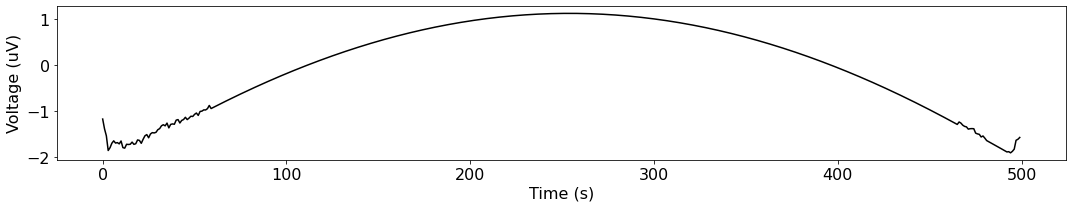

In [8]:
win_len = 1
win_spacing = .1

avg_window, window_starts, costs = \
    sliding_window_matching(sig, fs, win_len, win_spacing, max_iterations=1000,
                            temperature=0.01)

plot_time_series(np.arange(0, win_len*fs), avg_window)

### Matlab

The matlab version is much faster since it used Markov Chain Monte Carlo sampling and can better handle large signals and a large number of iterations. However, it typically can't recover as accurate of a gaussian as the ndsp implmentation.

Strangely, the window length (winLen) and spacing (guard) below must be reduced to half to return the expected average window.

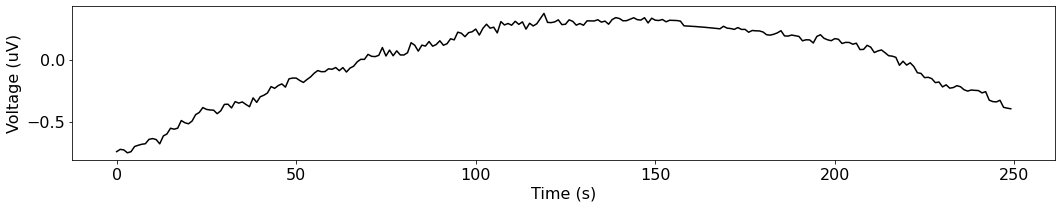

In [10]:
"""Matlab

dat = load("/home/rph/Projects/neurodsp/test.mat");
cfg.winLen = 250;
cfg.guard = 25;
cfg.Tfac = 0.01;
cfg.numIt = 5000;
cfg.verbose = 1;
out = bg_SWM(cfg, dat.dat);
best_z = out.best_z;
save("/home/rph/Projects/neurodsp/avg_matlab.mat", 'best_s');
"""

avg_window_matlab = loadmat("/home/rph/Projects/neurodsp/avg_matlab.mat")['best_z']

plot_time_series(np.arange(0, len(avg_window_matlab)), avg_window_matlab)